<a href="https://colab.research.google.com/github/CS23M005/DL_A1/blob/main/FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [452]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import random


In [453]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [454]:
samples_for_print = [];
unique_labels = np.unique(y_train)
u_l = np.copy(unique_labels)

while(len(unique_labels)>0):
  for i in range (0, len(y_train)):
    if(y_train[i] == unique_labels[0]):
      samples_for_print.append(X_train[i])
      unique_labels = np.setdiff1d(unique_labels,unique_labels[0])
      break


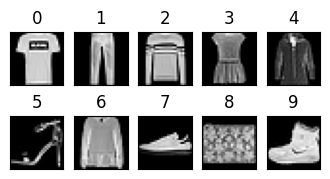

In [455]:
i = 1
rows = 2
cols = int(len(samples_for_print)/rows)
plt.figure(figsize = (4,2))
for img in samples_for_print:
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(u_l[i-1])
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    i = i+1
plt.show()

In [456]:
from random import seed
import random

def init_random(n1, n2):
  return [[random.uniform(0, 10) for i in range(n1)] for j in range(n2)]

def init_nn(n_inputs, n_layers, n_neurons, n_outputs):
  w = [0]*(n_layers+2)
  biases = []
  input_layer = init_random(n_inputs, n_neurons)
  w[1] = input_layer
  biases.append([0])
  biases.append(init_random(n_neurons, 1)[0])
  for i in range(2,n_layers+1):
    hidden_layer = init_random(n_neurons, n_neurons)
    w[i] = hidden_layer
    biases.append(init_random(n_neurons, 1)[0])
  output_layer = init_random(n_neurons, n_outputs)
  w[n_layers+1] = output_layer
  biases.append(init_random(n_outputs, 1)[0])
  return w, biases

seed(1)
n_inputs = 784
n_layers = 3
n_neurons = 32
n_outputs = 10
w,b = init_nn(n_inputs, n_layers, n_neurons, n_outputs)
w_old = w.copy()
b_old = b.copy()

In [457]:
aa=3
print(np.array(w[aa]).shape)
print(np.array(h[aa-1]).shape)

(32, 32)
(32,)


In [458]:

def ud_sigmoid(a):
  return 1/(1 + np.exp(-1*np.array(a)))

def ud_sigmoid_derivative(a):
  return ud_sigmoid(a) * (1-ud_sigmoid(a))

def ud_softmax(a):
  e = np.exp(a)
  return e / e.sum()
def ud_softmax_derivative(x):
  return softmax(x) * (1-softmax(x))

def forward_prop(w, b, sample, n_layers):
  a = []
  h = []
  h.append(sample)
  a.append([0])
  for i in range(1, n_layers+1):
    a.append(np.matmul(np.array(w[i]),np.array(h[i-1]))+b[i])
    h.append(ud_sigmoid(a[i]))
  a.append(np.matmul(w[n_layers+1],h[n_layers])+b[n_layers+1])
  y = ud_softmax(a[n_layers+1])
  return y, a, h

sampleid = 12000
sample = X_train[sampleid].flatten()
y_actual = y_train[sampleid]
sample.shape

y, a, h = forward_prop(w, b, sample, n_layers)





In [459]:
def sigmoid(x):
  return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
  return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
  return np.maximum(0,x)

def Relu_derivative(x):
  return 1*(x>0)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return (1 - (np.tanh(x)**2))

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
  return softmax(x) * (1-softmax(x))

def oneHotEncode(y_actual, n_outputs):
  Ydata = np.zeros(n_outputs)
  Ydata[int(y_actual)] = 1
  return Ydata



In [460]:

def backprop(y_hat, y_actual, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs):

    L = len(w)-1
    gradient_a = [0]*(L+1)
    gradient_w = [0]*(L+1)
    gradient_b = [0]*(L+1)
    gradient_h = [0]*(L+1)
    y = oneHotEncode(y_actual, n_outputs)

    if loss == 'crossentropy':
      gradient_a[L] = y_hat-y
    elif loss == 'mse':
      gradient_a[L] = np.multiply(2 * (y_hat - y), np.multiply(y_hat, (1 - y_hat)))

    for k in range(L,0,-1):
      gradient_w[k] = (np.outer(gradient_a[k], h[k-1].transpose()))
      gradient_b[k] = gradient_a[k]

      if (k > 1):
        if activation_f == 'sigmoid':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(sigmoid_derivative(a[k-1]))

        elif activation_f == 'relu':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(Relu_derivative(a[k-1]))

        elif activation_f == 'tanh':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(tanh_derivative(a[k-1]))

    return gradient_w, gradient_b


In [461]:

activation_f = 'sigmoid'
batch_size = 1
loss = 'crossentropy'
ud_lambda = 0.5

def sgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta):
  w,b = init_nn(n_inputs, n_layers, n_neurons, n_outputs)
  for i in range(5):
    dw, db = 0,0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      y_hat, a, h = forward_prop(w, b, sample, n_layers)
      dw, db = backprop(y_hat, y, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)
      for j in range(1, n_layers+2):
        w[j] = (w[j]-eta*dw[j]) - eta*ud_lambda*np.array(w[j])
        b[j] = b[j]-eta*db[j]
  return w,b,a,h



In [462]:
np.argmax([0.9, 0.8, 0.2], axis=0)

0

In [463]:
eta = 0.0001
w_n,b_n, a_n, h_n = sgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta)


In [ ]:
w_n[1]

In [465]:
np.array(w_n[1]).shape

(32, 784)

In [466]:
def accuracy(x_data,y_data, w, b):
  count = 0
  y_p = []
  for x,y in zip(x_data,y_data):
    sample = x.flatten()
    y_hat, a_dum, h_dum = forward_prop(w, b, sample, n_layers)
    y_pred = np.argmax(y_hat, axis=0)
    y_p.append(y_pred)
    if y_pred == y:
      count += 1
  accuracy = count/len(y_data)
  print(count)
  return accuracy, y_p

train_accuracy, yp = accuracy(X_train, y_train, w_n, b_n)
test_accuracy, ytp = accuracy(X_test, y_test, w_n, b_n)

print(yp[0:25])


6000
1000
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [467]:
print(train_accuracy*100)
print(test_accuracy*100)

10.0
10.0


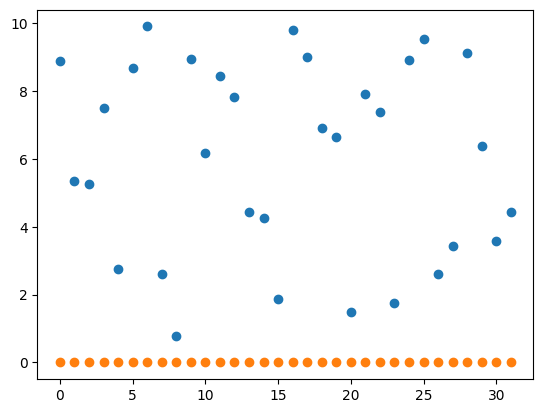

In [476]:
plt.plot(w_old[3][2][0:32], 'o')
plt.plot(w_n[2][8][0:32], 'o')
plt.show()

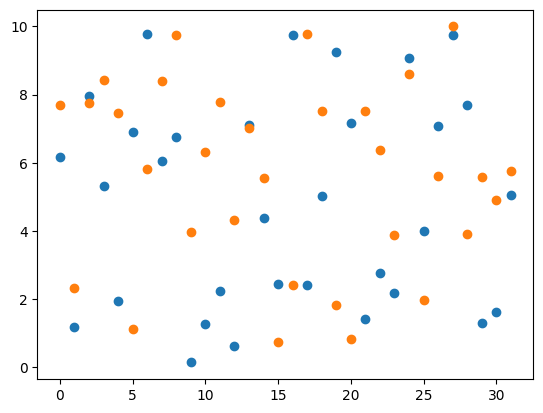

In [469]:
plt.plot(b_old[1], 'o')
plt.plot(b_n[1], 'o')
plt.show()

In [470]:
# import random
# random.randint(1,100)/1000

In [471]:
# sample = X_train[0].flatten()
# y_hat, a, h = forward_prop(w, b, sample, n_layers)
# dw, db = backprop(y_hat, y_train[0], a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)

In [472]:
# for i in range(0,n_layers+2):
#   print(np.array(b[i]).shape)